# Modelos basados en árboles

Método estadístico usado para problemas de clasificación y regresión. En general se basa en generar nodos, encontrando la mejor variable respecto al target de manera sucesiva, esto se hace mediante los criterios del gini o ganancia de información (entropía) buscando los mejores cortes de la variable tal que se optimice el target.

### Tipos de árbol de decisión

* ID3 (dicotomizador iterativo 3) fue desarrollado en 1986 por Ross Quinlan. El algoritmo crea un árbol de múltiples vías, encontrando para cada nodo (es decir, de manera codiciosa) la característica categórica que producirá la mayor ganancia de información para los objetivos categóricos. Los árboles crecen hasta su tamaño máximo y luego se suele aplicar un paso de poda para mejorar la capacidad del árbol de generalizar a datos invisibles.

* Chaid es un método de clasificación para generar árboles de decisión mediante estadísticos de chi-cuadrado para identificar divisiones óptimas.

* C4.5 es el sucesor de ID3 y eliminó la restricción de que las características deben ser categóricas definiendo dinámicamente un atributo discreto (basado en variables numéricas) que divide el valor del atributo continuo en un conjunto discreto de intervalos. C4.5 convierte los árboles entrenados (es decir, la salida del algoritmo ID3) en conjuntos de reglas if-else. Luego, se evalúa la precisión de cada regla para determinar el orden en el que deben aplicarse. La poda se realiza eliminando la condición previa de una regla si la precisión de la regla mejora sin ella.

* C5.0 Mejora de C4.5. Utiliza menos recursos de memoria e incluye el gini como métrica de elección de variables relevantes.

* CART (árboles de clasificación y regresión) es muy similar a C4.5, pero se diferencia en que admite variables objetivo numéricas (regresión).

* https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* https://www.cienciadedatos.net/documentos/py07_arboles_decision_python.html
* https://www.ibm.com/docs/es/spss-modeler/SaaS?topic=nodes-chaid-node

### Poda 

Es usado para mejorar el rendimiento y evitar el sobreajuste.

Existen dos conceptos:**prepuning** y **postpuning**

* Prepuning: Hacer uso de los hiperparámetros para controlar el crecimiento de los árboles y que se ajusten en exceso a los datos de entrenamiento.
* Postpuning: Hacer uso del cost complexity. En donde a mayor valor se reduce la profundidad y se evita el sobreajuste.

1. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
2. https://scikit-learn.org/0.24/auto_examples/tree/plot_cost_complexity_pruning.html
3. https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
4. https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial

## Implementación

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

### Carga de librerías 

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import warnings
import seaborn as sns
import timeit
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from chefboost import Chefboost as chef
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")

In [2]:
def plot_confusion_matrix(y_train_pred,y_train,dom,classes):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train,y_train_pred)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.xlabel("Prediction",fontsize=12,fontweight='bold')
    plt.ylabel("Real",fontsize=12,fontweight='bold')
    plt.tight_layout()
    plt.show()

### Ruta

In [3]:
ruta_input="C:/Users/Omar/Desktop/Omar/Temas data science/Bases/Credit car"
ruta_objetos="C:/Users/Omar/Desktop/Omar/Temas data science/Quinta Semana/Objetos"

In [4]:
base_input=pd.read_excel(os.path.join(ruta_input,"default of credit card clients.xls"),header=1)

In [5]:
base_input.shape

(30000, 25)

In [6]:
base_input.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
base_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

### Renombramos dataset 

In [8]:
base_input=base_input.iloc[:,1:]

In [9]:
colum_base=["credito_otorgado($)","genero","educacion","estado_civil","edad","marca_pago_mes_6","marca_pago_mes_5",
            "marca_pago_mes_4","marca_pago_mes_3","marca_pago_mes_2","marca_pago_mes_1","estado_cuenta_mes_6($)",
            "estado_cuenta_mes_5($)","estado_cuenta_mes_4($)","estado_cuenta_mes_3($)","estado_cuenta_mes_2($)",
            "estado_cuenta_mes_1($)","monto_pago_anterior_6($)","monto_pago_anterior_5($)","monto_pago_anterior_4($)",
            "monto_pago_anterior_3($)","monto_pago_anterior_2($)","monto_pago_anterior_1($)","incumplimiento_sgte_mes"]

In [10]:
base_input.columns=colum_base

### featuring engineering  

In [11]:
base_input.loc[base_input['genero']==1,'genero']='masculino'
base_input.loc[base_input['genero']==2,'genero']='femenino'
base_input.loc[(base_input['educacion']>3) | (base_input['educacion']==0),'educacion']='otros'
base_input.loc[base_input['educacion']==1,'educacion']='posgrado'
base_input.loc[base_input['educacion']==2,'educacion']='universidad'
base_input.loc[base_input['educacion']==3,'educacion']='bachillerato'
base_input.loc[(base_input['estado_civil']==3) | (base_input['estado_civil']==0),'estado_civil']='otros'
base_input.loc[base_input['estado_civil']==1,'estado_civil']='casado'
base_input.loc[base_input['estado_civil']==2,'estado_civil']='soltero'

In [12]:
base_dummies=pd.get_dummies(base_input[['genero','educacion','estado_civil']])
base_input=pd.concat([base_input,base_dummies],axis=1)
base_input.drop(columns=["genero","educacion","estado_civil","edad"],inplace=True)

**Estandarización**

In [13]:
base=base_input.copy()
X=base_input.drop(columns=["incumplimiento_sgte_mes"])

In [14]:
Y=base_input[["incumplimiento_sgte_mes"]]
Y['incumplimiento_sgte_mes']=Y['incumplimiento_sgte_mes'].apply(int)

In [15]:
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)
X_scaler = pd.DataFrame(X_scaler)
X_scaler.columns = X.columns

### Train y test para el modelo

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler, Y, test_size=0.3, random_state=123)
columns = X_train.columns

###  Balanceo

In [17]:
bal = SMOTE(random_state=23)
databal_X,databal_y= bal.fit_resample(X_train, y_train.values.ravel())
columns=X_train.columns.to_list()
databal_X = pd.DataFrame(data=databal_X,columns=columns )
databal_y= pd.DataFrame(data=databal_y,columns=['y'])

print("Tamaño de X_train: ",len(X_train))
print("Tamaño de bal_data_x: ",len(databal_X))

Tamaño de X_train:  21000
Tamaño de bal_data_x:  32624


In [18]:
print("cantidad de registros 0:",len(databal_y[databal_y['y']==0]))
print("cantidad de registros 1:",len(databal_y[databal_y['y']==1]))

cantidad de registros 0: 16312
cantidad de registros 1: 16312


In [19]:
X_trainbal=databal_X.copy()
y_trainbal=databal_y.copy()

### Implementación del modelo - Chaid

Usaremos la librería de chefboost

https://pypi.org/project/chefboost/

Otra alternativa puede ser Rambatino

https://github.com/Rambatino/CHAID

Definiremos el algoritmo a usar

In [20]:
databal_y.rename(columns={'y':'Decision'},inplace=True)
databal_y.loc[databal_y['Decision']==1,'Decision']='si'
databal_y.loc[databal_y['Decision']==0,'Decision']='no'
data_train=pd.concat([databal_X,databal_y],axis=1)

In [21]:
data_train.shape

(32624, 29)

In [22]:
data_train['Decision'].dtypes

dtype('O')

In [23]:
config = {'algorithm': 'CHAID'}

In [24]:
data_train_1=data_train.copy()

In [25]:
start_time = timeit.default_timer()
model = chef.fit(data_train_1, config = config)
elapsed = timeit.default_timer() - start_time

[INFO]:  2 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...
-------------------------
finished in  11472.715214729309  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  89.09698381559588 % on  32624  instances
Labels:  ['no' 'si']
Confusion matrix:  [[14749, 1994], [1563, 14318]]
Precision:  88.0905 %, Recall:  90.4181 %, F1:  89.2391 %


In [26]:
print("La ejecución fue de: ",elapsed/60)

La ejecución fue de:  191.28441256833332


Guardamos el modelo en un pickle

filename = 'model_chaid.sav'
pickle.dump(model, os.path.join(ruta_objetos,filename), 'wb')
#para cargar:
#loaded_model = pickle.load(open(os.path.join(ruta_objetos,filename), 'rb'))

Test

In [31]:
y_test_original=y_test.copy()

In [32]:
y_test.rename(columns={'incumplimiento_sgte_mes':'Decision'},inplace=True)
y_test.loc[y_test['Decision']==1,'Decision']='si'
y_test.loc[y_test['Decision']==0,'Decision']='no'
data_test=pd.concat([X_test,y_test],axis=1)

In [33]:
data_test_1=data_test.copy()

In [34]:
prediction=[]
for index, instance in data_test.iterrows():
    prediction_0 = chef.predict(model, instance)
    prediction.append(prediction_0)

**Evaluación del modelo**

In [35]:
prediction=pd.DataFrame(prediction)

In [36]:
labels = np.array(["no", "si"])
confusion_matrix_1 = confusion_matrix(y_test, prediction, labels = labels)
pd.DataFrame(confusion_matrix_1, index = labels, columns = labels)

,no,si
no,5152,1900
si,987,961


In [37]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

          no       0.84      0.73      0.78      7052
          si       0.34      0.49      0.40      1948

    accuracy                           0.68      9000
   macro avg       0.59      0.61      0.59      9000
weighted avg       0.73      0.68      0.70      9000



### Implementación del modelo - Cart

**Sklearn**

En primer lugar, generaremos un árbol de decisión sin mayor restricción en hiperparámetros

In [38]:
decision_tree=DecisionTreeClassifier(random_state=741)

In [39]:
start_time = timeit.default_timer()
model_2 = decision_tree.fit(X_trainbal,y_trainbal)
elapsed = timeit.default_timer() - start_time

In [40]:
print("La ejecución fue de: ",elapsed/60)

La ejecución fue de:  0.017145581666651803


In [41]:
predict_train_2=model_2.predict(X_train)
predict_test_2=model_2.predict(X_test)

In [42]:
print("Train")
print(classification_report(y_train, predict_train_2))

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16312
           1       0.99      0.98      0.99      4688

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



In [43]:
print("Test")
print(classification_report(y_test_original, predict_test_2))

Test
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      7052
           1       0.34      0.49      0.40      1948

    accuracy                           0.68      9000
   macro avg       0.59      0.61      0.59      9000
weighted avg       0.73      0.68      0.70      9000



Notamos que el modelo a **sobreajustado** al conjunto de entrenamiento.

In [44]:
base_bkp_train=pd.concat([X_train,y_train],axis=1)

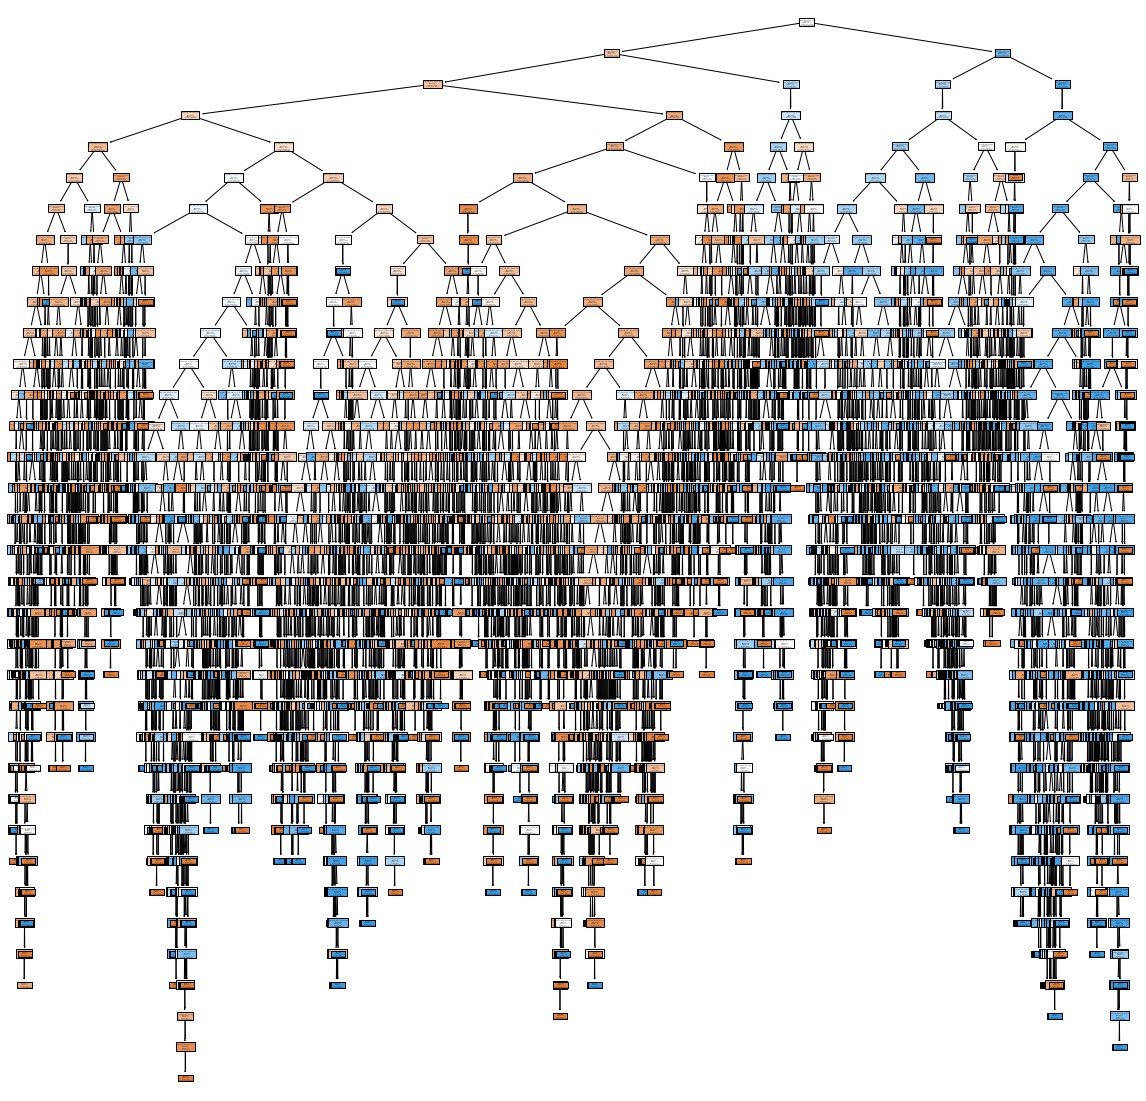

In [45]:
plt.figure(figsize=(20,20))
features = base_bkp_train.columns
classes = ['No incumple pago','Si incumple pago']
tree.plot_tree(model_2,feature_names=features,class_names=classes,filled=True)
plt.show()

### Poda de árboles 

**Prepuning**

Aquí definiremos los posibles valores de los hiperparámetros para evitar el sobreajuste.

* max_depth: maximum depth of decision tree
* min_sample_split: The minimum number of samples required to split an internal node:
* min_samples_leaf: The minimum number of samples required to be at a leaf node.

In [46]:
params = {'max_depth': [2,3,4,5,6],
         'min_samples_split': [30,40,50,60],
         'min_samples_leaf': [10,20,30,40]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=808)

In [47]:
modelo_3 = DecisionTreeClassifier()
gcv = GridSearchCV(estimator=modelo_3,param_grid=params,n_jobs=-1, cv=cv, scoring='f1')

start_time = timeit.default_timer()
gcv.fit(X_trainbal,y_trainbal)
elapsed_3 = timeit.default_timer() - start_time

In [48]:
print("La ejecución fue de: ",elapsed_3/60)

La ejecución fue de:  1.3085845016666704


Guardando modelo

In [49]:
filename = 'model_best_arbol_gridcv.sav'
pickle.dump(gcv, open(os.path.join(ruta_objetos,filename), 'wb'))
#para cargar:
#loaded_model = pickle.load(open(os.path.join(ruta_objetos,filename), 'rb'))

Veamos el resultado

In [50]:
means = gcv.cv_results_['mean_test_score']
stds = gcv.cv_results_['std_test_score']
params = gcv.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("Promedio del score es %f, con std de: (%f), y parametros: %r" % (mean, stdev, param))

Promedio del score es 0.655946, con std de: (0.016494), y parametros: {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 30}
Promedio del score es 0.655946, con std de: (0.016494), y parametros: {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 40}
Promedio del score es 0.655946, con std de: (0.016494), y parametros: {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 50}
Promedio del score es 0.655946, con std de: (0.016494), y parametros: {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 60}
Promedio del score es 0.655946, con std de: (0.016494), y parametros: {'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 30}
Promedio del score es 0.655946, con std de: (0.016494), y parametros: {'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 40}
Promedio del score es 0.655946, con std de: (0.016494), y parametros: {'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 50}
Promedio del score es 0.655946, con std de: (0.0

In [51]:
gcv.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=50)

In [52]:
model_4=gcv.best_estimator_

**Analizando desempeño**

In [53]:
predict_train_4=model_4.predict(X_train)
predict_test_4=model_4.predict(X_test)

In [54]:
print("Train")
print(classification_report(y_train, predict_train_4))

Train
              precision    recall  f1-score   support

           0       0.88      0.78      0.82     16312
           1       0.44      0.62      0.51      4688

    accuracy                           0.74     21000
   macro avg       0.66      0.70      0.67     21000
weighted avg       0.78      0.74      0.75     21000



In [55]:
print("Test")
print(classification_report(y_test_original, predict_test_4))

Test
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      7052
           1       0.42      0.60      0.49      1948

    accuracy                           0.73      9000
   macro avg       0.65      0.68      0.66      9000
weighted avg       0.78      0.73      0.75      9000



In [56]:
from sklearn.metrics import confusion_matrix
labels = np.array([0, 1])
confusion_matrix_4 = confusion_matrix(y_test_original, predict_test_4, labels = labels)
pd.DataFrame(confusion_matrix_4, index = labels, columns = labels)

,0,1
0,5437,1615
1,782,1166


Test Confusion matrix


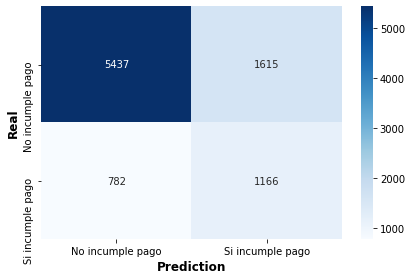

In [57]:
plot_confusion_matrix(predict_test_4,y_test_original,dom='Test',classes=classes)

**Graficando árbol**

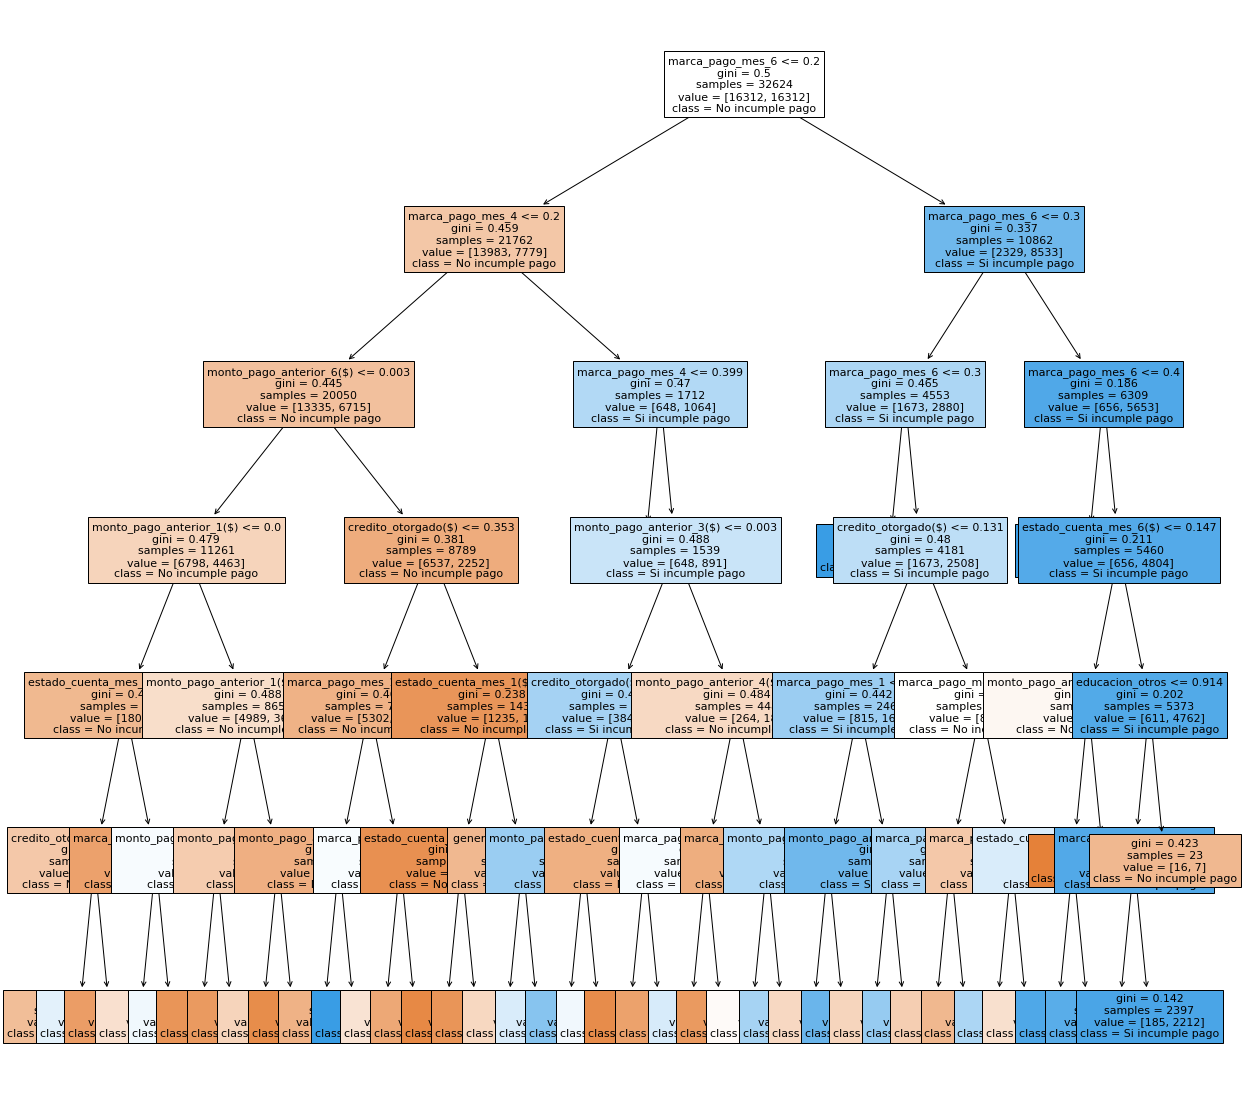

In [58]:
plt.figure(figsize=(20,20))
features = base_bkp_train.columns
classes = ['No incumple pago','Si incumple pago']
tree.plot_tree(model_4,feature_names=features,class_names=classes,filled=True,fontsize=11)
plt.show()

**Variables importantes**

In [59]:
variables_importantes_4=model_4.feature_importances_

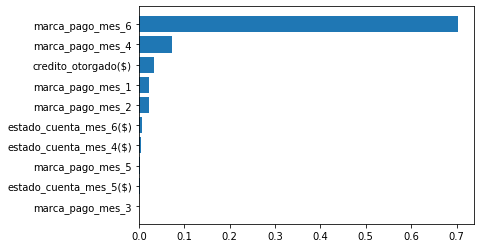

In [60]:
graf= pd.DataFrame(variables_importantes_4,X_train.columns)
graf.rename(columns={0:'valor'},inplace=True)
graf.sort_values('valor')
graf=graf.iloc[:-18]
graf=graf.sort_values('valor')
plt.barh(graf.index,graf['valor'])
plt.show()

In [61]:
graf

,valor
marca_pago_mes_3,0.000000
estado_cuenta_mes_5($),0.001460
marca_pago_mes_5,0.001618
estado_cuenta_mes_4($),0.003429
estado_cuenta_mes_6($),0.007516
marca_pago_mes_2,0.022858
marca_pago_mes_1,0.023124
credito_otorgado($),0.032870
marca_pago_mes_4,0.073810
marca_pago_mes_6,0.702841


Vemos que la variable **"marca_pago_mes_6"** es la variable que aporta más al modelo.

### Ejercicio

Implementar modelo con las variables más importantes del árbol previo.

**Post pruning**

Cost Complexity Pruning

Busca encontrar el mejor valor de $\alpha$ (>0), tal que minimice el sobreajuste. leer: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

In [62]:
path = modelo_3.cost_complexity_pruning_path(X_trainbal, y_trainbal)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

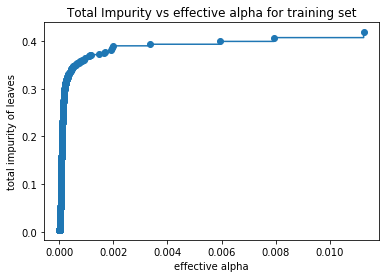

In [63]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

A medida que aumenta el alfa, se poda una mayor parte del árbol, lo que aumenta la impureza total de sus hojas

In [64]:
start_time = timeit.default_timer()
model_6 = []
for ccp_alpha in ccp_alphas:
    model_5 = DecisionTreeClassifier(random_state=746, ccp_alpha=ccp_alpha)
    model_5.fit(X_trainbal, y_trainbal)
    model_6.append(model_5)
elapsed_4 = timeit.default_timer() - start_time    
print("Número de nodos en el último árbol es: {} con ccp_alpha: {}".format(
      model_6[-1].tree_.node_count, ccp_alphas[-1]))

Número de nodos en el último árbol es: 3 con ccp_alpha: 0.081415103290716


In [65]:
print("la ejecución fue de: ",elapsed_4/60)

la ejecución fue de:  42.37234965000001


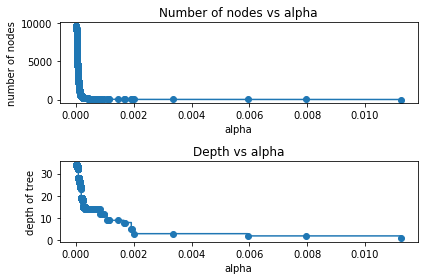

In [66]:
model_6 = model_6[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [model_5.tree_.node_count for model_5 in model_6]
depth = [model_5.tree_.max_depth for model_5 in model_6]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Validando con la data de prueba

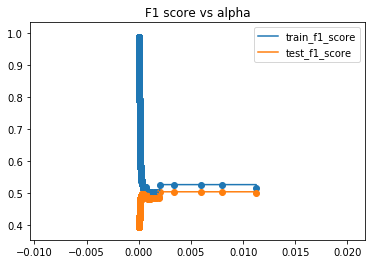

In [67]:
train_f1 = []
test_f1 = []
for c in model_6:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_f1.append(f1_score(y_train_pred,y_train))
    test_f1.append(f1_score(y_test_pred,y_test_original))

plt.scatter(ccp_alphas,train_f1)
plt.scatter(ccp_alphas,test_f1)
plt.plot(ccp_alphas,train_f1,label='train_f1_score',drawstyle="steps-post")
plt.plot(ccp_alphas,test_f1,label='test_f1_score',drawstyle="steps-post")
plt.legend()
plt.title('F1 score vs alpha')
plt.show()


In [68]:
dic={'alpha':ccp_alphas,'f1_train':train_f1,'f1_test':test_f1}
alpha=pd.DataFrame(dic)
alpha.loc[alpha['f1_test']>0.49]

,alpha,f1_train,f1_test
2428,0.000239,0.543727,0.490124
2429,0.000241,0.543609,0.490337
2430,0.000242,0.543609,0.490337
2431,0.000243,0.543609,0.490337
2432,0.000243,0.543609,0.490337
2433,0.000250,0.542382,0.491478
2436,0.000257,0.540119,0.491596
2437,0.000259,0.539618,0.491381
2438,0.000259,0.538676,0.490706
2439,0.000260,0.538676,0.490706


El parámetro $\alpha$ óptimo es **0.000629**.

**Construyendo el árbol**

In [69]:
model_7 = DecisionTreeClassifier(random_state=111,ccp_alpha=0.000629)
model_7.fit(X_trainbal,y_trainbal)
y_train_pred = model_7.predict(X_train)
y_test_pred = model_7.predict(X_test)

Guardar modelo

In [70]:
filename = 'model_best_arbol_cpp.sav'
pickle.dump(model_7, open(os.path.join(ruta_objetos,filename), 'wb'))

In [71]:
variables_importantes_7=model_7.feature_importances_

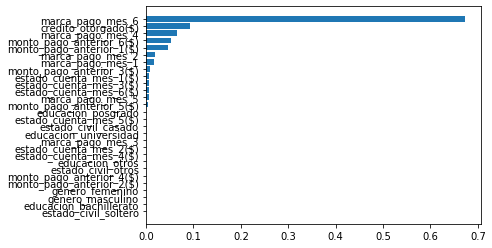

In [72]:
graf= pd.DataFrame(variables_importantes_7,X_train.columns)
graf.rename(columns={0:'valor'},inplace=True)
graf=graf.sort_values('valor')
plt.barh(graf.index,graf['valor'])
plt.show()

In [73]:
graf.sort_values('valor',ascending=False)

,valor
marca_pago_mes_6,0.672781
credito_otorgado($),0.091812
marca_pago_mes_4,0.064436
monto_pago_anterior_6($),0.052186
monto_pago_anterior_1($),0.046041
marca_pago_mes_2,0.019380
marca_pago_mes_1,0.017593
monto_pago_anterior_3($),0.007335
estado_cuenta_mes_1($),0.006954
estado_cuenta_mes_3($),0.005993


Graficando el árbol

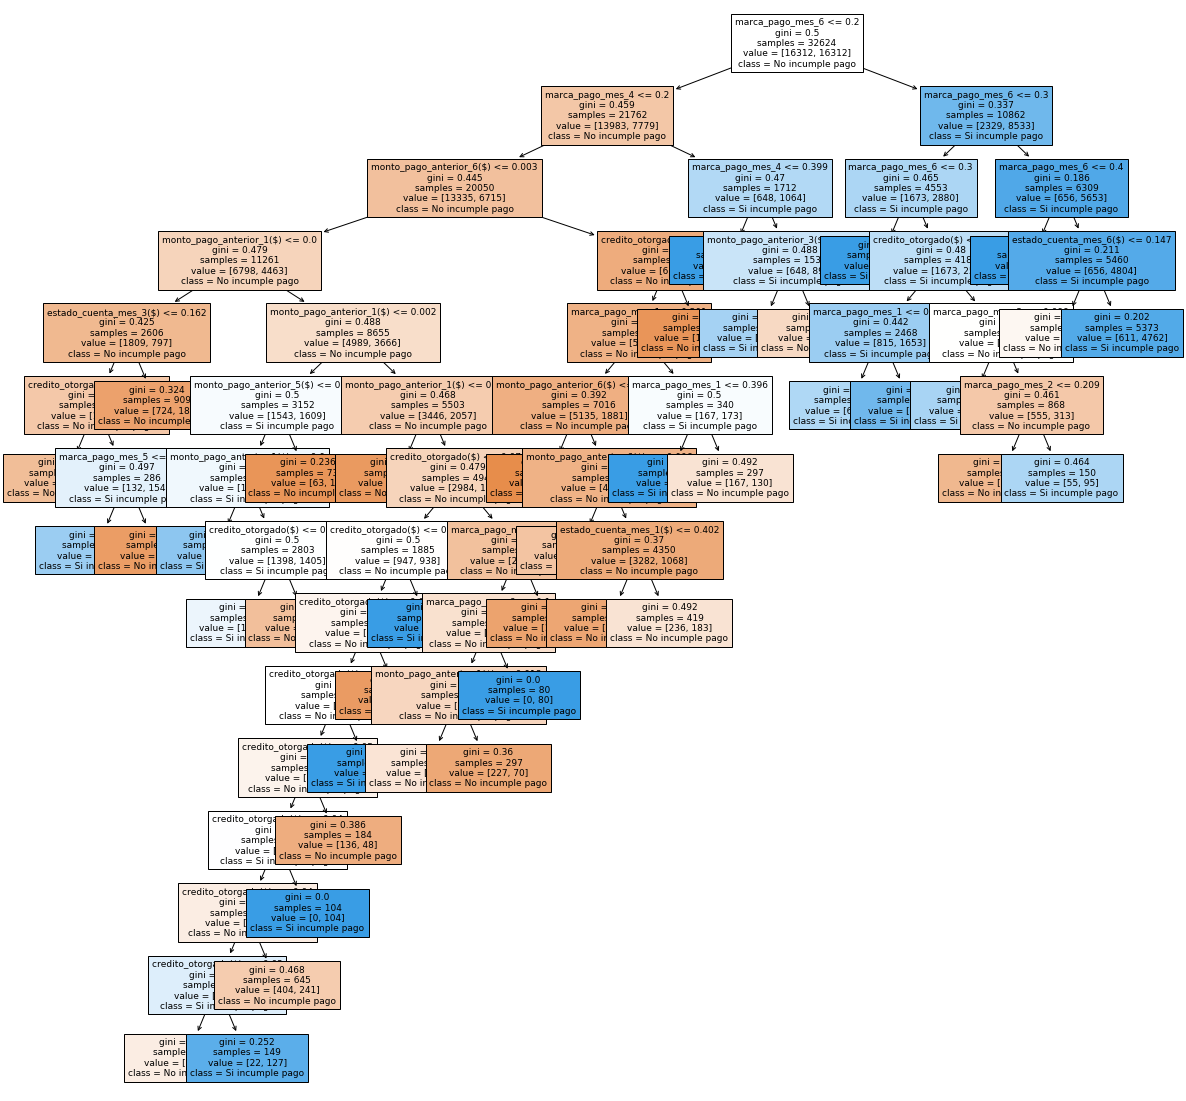

In [74]:
plt.figure(figsize=(20,20))
features = base_bkp_train.columns
classes = ['No incumple pago','Si incumple pago']
tree.plot_tree(model_7,feature_names=features,class_names=classes,filled=True,fontsize=9)
plt.show()

Revisando el desempeño del modelo

Test Confusion matrix


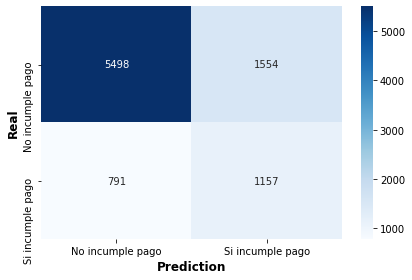

In [75]:
plot_confusion_matrix(y_test_pred,y_test_original,dom='Test',classes=classes)

In [76]:
print("Test")
print(classification_report(y_test_original, y_test_pred))

Test
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      7052
           1       0.43      0.59      0.50      1948

    accuracy                           0.74      9000
   macro avg       0.65      0.69      0.66      9000
weighted avg       0.78      0.74      0.75      9000



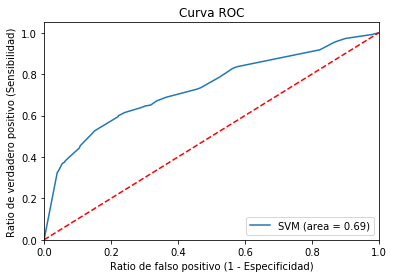

In [78]:
curva_roc = roc_auc_score(y_test, model_7.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test_original, model_7.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % curva_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de falso positivo (1 - Especificidad)')
plt.ylabel('Ratio de verdadero positivo (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.savefig('Curva_roc')
plt.show()

In [79]:
print("AUC: ",curva_roc)
print("Gini: ",2*curva_roc-1)

AUC:  0.6867897437749031
Gini:  0.3735794875498062


In [80]:
from sklearn.metrics import confusion_matrix
labels = np.array([0, 1])

confusion_matrix_0 = confusion_matrix(y_train, y_train_pred, labels = labels)
confusion_matrix_1 = confusion_matrix(y_test_original, y_test_pred, labels = labels)
##
acc_0=(confusion_matrix_0[0][0]+confusion_matrix_0[1][1])/(confusion_matrix_0[0][0]+confusion_matrix_0[0][1]+confusion_matrix_0[1][0]+confusion_matrix_0[1][1])
acc=(confusion_matrix_1[0][0]+confusion_matrix_1[1][1])/(confusion_matrix_1[0][0]+confusion_matrix_1[0][1]+confusion_matrix_1[1][0]+confusion_matrix_1[1][1])
##
prec_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[1][1]+confusion_matrix_0[0][1])
prec=(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1]+confusion_matrix_1[0][1])
##
sens_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[1][1]+confusion_matrix_0[1][0])
sens=(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1]+confusion_matrix_1[1][0])
##
f1_score=2*(sens*prec)/(sens+prec)
f1_score_0=2*(sens_0*prec_0)/(sens_0+prec_0)
##
beta=2
f2_score=(1+beta**2)*((sens*prec)/(beta**2*prec+sens))
f2_score_0=(1+beta**2)*((sens_0*prec_0)/(beta**2*prec_0+sens_0))
##
curva_roc_0 = roc_auc_score(y_train, model_7.predict(X_train))

In [81]:
Tabla=pd.DataFrame({"Etapa":["Train","Test"],"Modelo":["DT","DT"],"Accuracy":[acc_0,acc],
                    "Precision":[prec_0,prec],"Sensibility":[sens_0,sens],
                    "F1 Score":[f1_score_0,f1_score],"F2 Score":[f2_score_0,f2_score],
                    "AUC":[curva_roc_0,curva_roc],"Gini":[2*curva_roc_0-1,2*curva_roc-1]})
Tabla

,Etapa,Modelo,Accuracy,Precision,Sensibility,F1 Score,F2 Score,AUC,Gini
0,Train,DT,0.745952,0.449127,0.609215,0.517063,0.568675,0.697233,0.394465
1,Test,DT,0.739444,0.426780,0.593943,0.496673,0.550795,0.686790,0.373579


### FIN